## Loading Keras

In [1]:
import keras
keras.__version__

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

# Overfitting and underfitting

In all the examples we saw previously -- movie review sentiment prediction and house price regression -- we could notice that the performance of our model on the held-out validation data would always peak after a few epochs and would then start 
degrading, i.e. our model would quickly start to _overfit_ to the training data. Overfitting happens in every single machine learning problem. Learning how to deal with overfitting is essential to mastering machine learning.

The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of course, but you do not control generalization; you can only adjust the model based on its training data.

At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on test data. While this is happening, your model is said to _under-fit_: there is still progress to be made; the network hasn't yet modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops improving, validation metrics stall then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.

To prevent a model from learning misleading or irrelevant patterns found in the training data, _the best solution is of course to get more training data_. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called _regularization_. Let's review some of the most common regularization techniques, and let's apply them in practice to improve our movie classification model.

Let's prepare the data of the movie reviews from the IMDB data set:

In [2]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Fighting overfitting

## Reducing the network's size


The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is 
determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is 
often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore 
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any 
generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the 
MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying 
new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge 
is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in 
order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets 
-- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have 
enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be 
found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You 
will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the 
right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and 
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the 
validation loss.

Let's try this on our movie review classification network. Our original network was as such:

In [3]:
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

Now let's try to compare it with this smaller network:

In [4]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(8, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

Let's train the original network:

In [5]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 6s 254us/step - loss: 0.4438 - acc: 0.8245 - val_loss: 0.3286 - val_acc: 0.8848
Epoch 2/20
25000/25000 [==============================] - 5s 202us/step - loss: 0.2575 - acc: 0.9084 - val_loss: 0.2859 - val_acc: 0.8888
Epoch 3/20
25000/25000 [==============================] - 5s 216us/step - loss: 0.1992 - acc: 0.9286 - val_loss: 0.2821 - val_acc: 0.8887
Epoch 4/20
25000/25000 [==============================] - 6s 233us/step - loss: 0.1664 - acc: 0.9415 - val_loss: 0.2942 - val_acc: 0.8839
Epoch 5/20
25000/25000 [==============================] - 7s 273us/step - loss: 0.1427 - acc: 0.9502 - val_loss: 0.3119 - val_acc: 0.8804
Epoch 6/20
25000/25000 [==============================] - 6s 254us/step - loss: 0.1248 - acc: 0.9562 - val_loss: 0.3506 - val_acc: 0.8717
Epoch 7/20
25000/25000 [==============================] - 6s 234us/step - loss: 0.1099 - acc: 0.9625 - val_loss: 0.3592 - 

We now train the smaller network:

In [6]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 7s 273us/step - loss: 0.4885 - acc: 0.8174 - val_loss: 0.3819 - val_acc: 0.8708
Epoch 2/20
25000/25000 [==============================] - 7s 289us/step - loss: 0.2992 - acc: 0.9024 - val_loss: 0.3051 - val_acc: 0.8863
Epoch 3/20
25000/25000 [==============================] - 7s 271us/step - loss: 0.2278 - acc: 0.9224 - val_loss: 0.2813 - val_acc: 0.8902
Epoch 4/20
25000/25000 [==============================] - 7s 283us/step - loss: 0.1897 - acc: 0.9338 - val_loss: 0.2800 - val_acc: 0.8880
Epoch 5/20
25000/25000 [==============================] - 6s 255us/step - loss: 0.1642 - acc: 0.9436 - val_loss: 0.2872 - val_acc: 0.8855
Epoch 6/20
25000/25000 [==============================] - 6s 256us/step - loss: 0.1455 - acc: 0.9501 - val_loss: 0.2988 - val_acc: 0.8832
Epoch 7/20
25000/25000 [==============================] - 8s 320us/step - loss: 0.1291 - acc: 0.9570 - val_loss: 0.3142 - 

Here's a comparison of the validation losses of the original network and the smaller network. The dots are the validation loss values of 
the smaller network, and the crosses are the initial network (remember: a lower validation loss indicates a better model).

In [7]:
import matplotlib.pyplot as plt

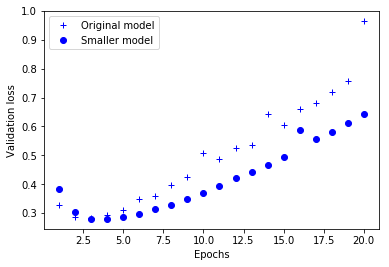

In [8]:
%matplotlib inline
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


As you can see, the smaller network starts overfitting later than the reference one (after 6 epochs rather than 4) and its performance 
degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [9]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [10]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 26s 1ms/step - loss: 0.4653 - acc: 0.7944 - val_loss: 0.2875 - val_acc: 0.8886
Epoch 2/20
25000/25000 [==============================] - 26s 1ms/step - loss: 0.2240 - acc: 0.9118 - val_loss: 0.2761 - val_acc: 0.8867
Epoch 3/20
25000/25000 [==============================] - 25s 985us/step - loss: 0.1257 - acc: 0.9537 - val_loss: 0.3967 - val_acc: 0.8708
Epoch 4/20
25000/25000 [==============================] - 26s 1ms/step - loss: 0.0701 - acc: 0.9812 - val_loss: 0.4333 - val_acc: 0.8814
Epoch 5/20
25000/25000 [==============================] - 24s 957us/step - loss: 0.0838 - acc: 0.9864 - val_loss: 0.5035 - val_acc: 0.8820
Epoch 6/20
25000/25000 [==============================] - 24s 963us/step - loss: 0.0821 - acc: 0.9878 - val_loss: 0.5151 - val_acc: 0.8776
Epoch 7/20
25000/25000 [==============================] - 25s 1ms/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.6315 - v

Here's how the bigger network fares compared to the reference one. The dots are the validation loss values of the bigger network, and the 
crosses are the initial network.

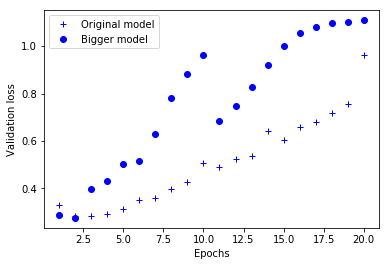

In [11]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also 
more noisy.

Meanwhile, here are the training losses for our two networks:

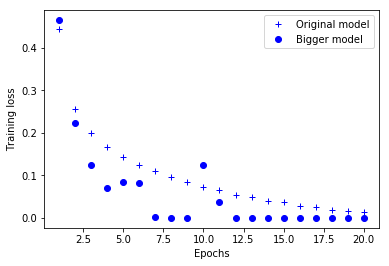

In [12]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be 
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large 
difference between the training and validation loss).

## Adding weight regularization


You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the 
"simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some 
training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and 
simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer 
parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity 
of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called 
"weight regularization", and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This 
cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the 
"L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called 
the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. 

In Keras, weight regularization is added by passing _weight regularizer instances_ to layers as keyword arguments. Let's add L2 weight 
regularization to our movie review classification network:

In [13]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
l2_model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of 
the network. Note that because this penalty is _only added at training time_, the loss for this network will be much higher at training 
than at test time.

Here's the impact of our L2 regularization penalty:

In [15]:
l2_model_hist = l2_model.fit(x_train, y_train,epochs=20,batch_size=512,validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 5s 205us/step - loss: 0.4879 - acc: 0.8152 - val_loss: 0.3895 - val_acc: 0.8656
Epoch 2/20
25000/25000 [==============================] - 5s 193us/step - loss: 0.3100 - acc: 0.9061 - val_loss: 0.3306 - val_acc: 0.8891
Epoch 3/20
25000/25000 [==============================] - 5s 193us/step - loss: 0.2656 - acc: 0.9203 - val_loss: 0.3303 - val_acc: 0.8871
Epoch 4/20
25000/25000 [==============================] - 5s 196us/step - loss: 0.2459 - acc: 0.9287 - val_loss: 0.3415 - val_acc: 0.8821
Epoch 5/20
25000/25000 [==============================] - 5s 193us/step - loss: 0.2323 - acc: 0.9351 - val_loss: 0.3806 - val_acc: 0.8687
Epoch 6/20
25000/25000 [==============================] - 5s 192us/step - loss: 0.2237 - acc: 0.9389 - val_loss: 0.3676 - val_acc: 0.8750
Epoch 7/20
25000/25000 [==============================] - 5s 195us/step - loss: 0.2173 - acc: 0.9410 - val_loss: 0.3747 - 

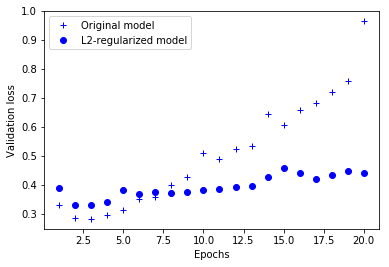

In [16]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses), even though both models have the same number of parameters.

## Adding dropout


Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his 
students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of 
output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5,1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test 
time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

This technique may seem strange and arbitrary. Why would this help reduce overfitting? The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant ("conspiracies"), which the network would start memorizing if no noise was present. 

In Keras you can introduce dropout in a network via the `Dropout` layer, which gets applied to the output of layer right before it, e.g.:

``` python
model.add(layers.Dropout(0.5))
```

Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting:

In [17]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [18]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 5s 213us/step - loss: 0.5906 - acc: 0.6839 - val_loss: 0.4324 - val_acc: 0.8620
Epoch 2/20
25000/25000 [==============================] - 5s 198us/step - loss: 0.4359 - acc: 0.8186 - val_loss: 0.3475 - val_acc: 0.8706
Epoch 3/20
25000/25000 [==============================] - 5s 198us/step - loss: 0.3469 - acc: 0.8714 - val_loss: 0.2912 - val_acc: 0.8872
Epoch 4/20
25000/25000 [==============================] - 5s 197us/step - loss: 0.2881 - acc: 0.8983 - val_loss: 0.2765 - val_acc: 0.8884
Epoch 5/20
25000/25000 [==============================] - 5s 198us/step - loss: 0.2531 - acc: 0.9136 - val_loss: 0.2802 - val_acc: 0.8884
Epoch 6/20
25000/25000 [==============================] - 5s 199us/step - loss: 0.2219 - acc: 0.9265 - val_loss: 0.2889 - val_acc: 0.8874
Epoch 7/20
25000/25000 [==============================] - 5s 198us/step - loss: 0.1967 - acc: 0.9357 - val_loss: 0.3212 - 

Let's plot the results:

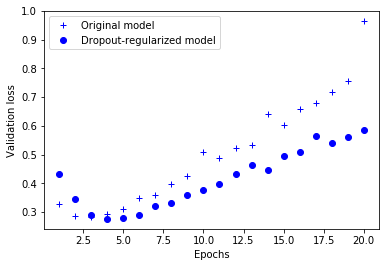

In [19]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


Again, a clear improvement over the reference network.

To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.